In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
import pandas as pd
import plotly.express as px

In [2]:
sns.set()

In [3]:
drowings = np.loadtxt("../data/drowning.txt")
drowings;

In [4]:
data = np.loadtxt("../data/factory.txt")
data

array([[ 83., 117., 101., 105.,  79.,  57.],
       [ 92., 109.,  93., 119.,  97.,  92.],
       [ 92., 114.,  92., 116., 103., 104.],
       [ 46., 104.,  86., 102.,  79.,  77.],
       [ 67.,  87.,  67., 116.,  92., 100.]])

## Pooled model

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu, \sigma) \\
\mu &\sim \mathcal{N}(92, 100) \\
\sigma &\sim |\mathcal{N}|(0, 100) \\
\end{align*}


In [5]:
data_vec = data.ravel()
data_vec

array([ 83., 117., 101., 105.,  79.,  57.,  92., 109.,  93., 119.,  97.,
        92.,  92., 114.,  92., 116., 103., 104.,  46., 104.,  86., 102.,
        79.,  77.,  67.,  87.,  67., 116.,  92., 100.])

In [6]:
pd.Series(data_vec).describe()

count     30.000000
mean      92.933333
std       18.001788
min       46.000000
25%       83.750000
50%       92.500000
75%      104.000000
max      119.000000
dtype: float64

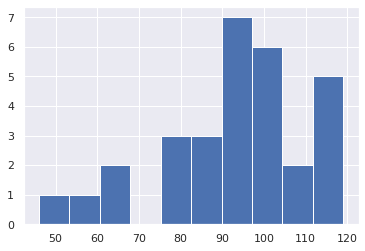

In [7]:
plt.hist(data_vec);

<AxesSubplot:>

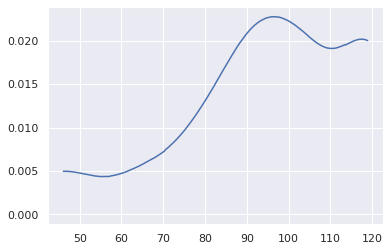

In [8]:
az.plot_kde(data_vec)

In [9]:
(120 - 92.5)/3

9.166666666666666

In [10]:
import scipy
pd.DataFrame(scipy.stats.halfnorm.rvs(size=1000, scale=15)).describe()

0
count  1000.000000
mean     12.378766
std       9.427650
min       0.001230
25%       4.832958
50%      10.561929
75%      17.613610
max      50.302741

In [11]:
with pm.Model() as factory_pooled:
    mu = pm.Normal('mu', mu=92.5, sd=10)
    std = pm.HalfNormal('std', sd=15)
    y = pm.Normal('y', mu=mu, sd=std, observed=data_vec)
    trace_pooled = pm.sample(10_000)

/tmp/ipykernel_32884/3746291418.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_pooled = pm.sample(10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 7 seconds.


In [12]:
az.summary(trace_pooled)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu   92.883  3.200  86.822   98.879      0.018    0.013   32216.0   25921.0   
std  18.233  2.387  14.038   22.760      0.014    0.010   28820.0   26304.0   

     r_hat  
mu     1.0  
std    1.0

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'std'}>], dtype=object)

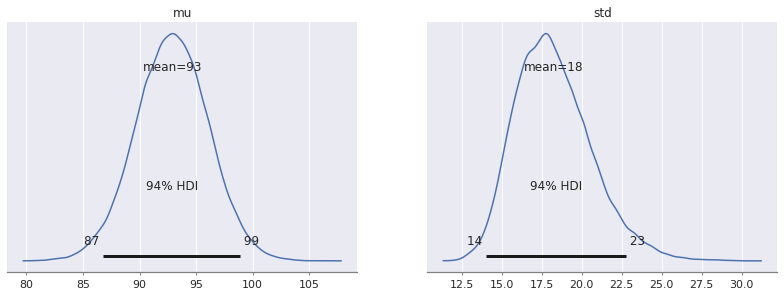

In [13]:
az.plot_posterior(trace_pooled)

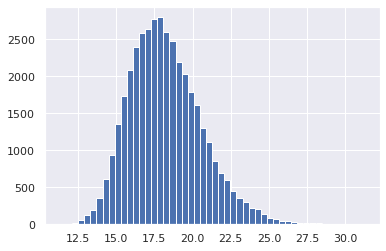

In [14]:
plt.hist(trace_pooled["std"], bins=50);

In [15]:
#with factory_pooled:
az.waic(trace_pooled)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 40000 posterior samples and 30 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -130.79     4.39
p_waic        1.96        -

There has been a warning during the calculation. Please check the results.

## Separate model

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu_j, \sigma_j) \\
\mu_{j} &\sim \mathcal{N}(0, 1) \\
\sigma_{j} &\sim |\mathcal{N}|(0, \sigma_j) \\
\end{align*}



In [16]:
#data.ravel(order="F")
#np.tile(np.arange(groups), meas)

groups = data.shape[1] # number of groups
meas = data.shape[0] # number of measurements per group
data_vec = data.ravel()
group_vec = np.tile(np.arange(groups), meas)

In [17]:
data_vec

array([ 83., 117., 101., 105.,  79.,  57.,  92., 109.,  93., 119.,  97.,
        92.,  92., 114.,  92., 116., 103., 104.,  46., 104.,  86., 102.,
        79.,  77.,  67.,  87.,  67., 116.,  92., 100.])

In [18]:
group_vec

array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5])

In [19]:
data.mean(axis=0)

array([ 76. , 106.2,  87.8, 111.6,  90. ,  86. ])

In [20]:
data.std(axis=0, ddof=1)

array([19.63415392, 11.81947545, 12.79453008,  7.56967635, 10.77032961,
       19.22238279])

In [21]:
with pm.Model() as factory_separate:
    group_mu = pm.Normal('group_mu', mu=92.5, sd=100, shape=groups)
    group_std = pm.HalfNormal('group_std', sd=100, shape=groups)
    y = pm.Normal('y', mu=group_mu[group_vec], sd=group_std[group_vec], observed=data_vec)
    trace_separate = pm.sample(10_000)


/tmp/ipykernel_32884/1392549784.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_separate = pm.sample(10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 12 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [22]:
az.summary(trace_separate)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
group_mu[0]    76.189  14.074   50.028  102.876      0.097    0.069   25784.0   
group_mu[1]   105.969   9.138   88.853  122.785      0.077    0.055   20800.0   
group_mu[2]    87.902   9.580   69.405  105.427      0.074    0.054   21968.0   
group_mu[3]   111.509   6.065  100.477  122.484      0.058    0.041   17512.0   
group_mu[4]    89.976   8.181   74.210  105.174      0.059    0.042   25853.0   
group_mu[5]    86.204  13.799   59.962  112.193      0.100    0.073   23337.0   
group_std[0]   28.884  15.399   10.436   55.400      0.117    0.088   24523.0   
group_std[1]   18.013  10.603    6.144   35.264      0.090    0.064   20887.0   
group_std[2]   19.289  11.058    6.729   37.829      0.090    0.064   21389.0   
group_std[3]   11.678   7.232    3.959   23.001      0.069    0.049   18792.0   
group_std[4]   16.290   9.388    5.717   32.052      0.075    0.056   23765.0   
group_std[5]   28.285  15.064   10.336   54.398      0.112    0.080   24108.0   

              ess_tail  r_hat  
group_mu[0]    18922.0    1.0  
group_mu[1]    15159.0    1.0  
group_mu[2]    15621.0    1.0  
group_mu[3]    11334.0    1.0  
group_mu[4]    18133.0    1.0  
group_mu[5]    16820.0    1.0  
group_std[0]   19141.0    1.0  
group_std[1]   17323.0    1.0  
group_std[2]   16820.0    1.0  
group_std[3]   12802.0    1.0  
group_std[4]   17415.0    1.0  
group_std[5]   19811.0    1.0

In [23]:
#plt.hist(trace_separate["group_std"][:, 5], bins=50);
px.histogram(trace_separate["group_std"][:, 5])#, bins=50);

<AxesSubplot:title={'center':'x'}>

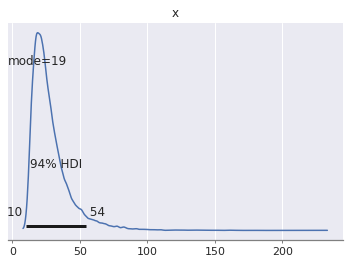

In [24]:
az.plot_posterior(trace_separate["group_std"][:, 5], point_estimate='mode')

<AxesSubplot:title={'center':'x'}>

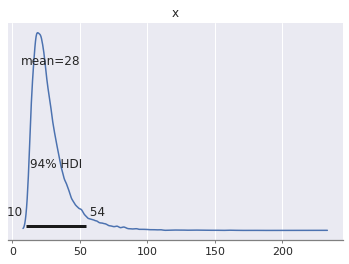

In [25]:
az.plot_posterior(trace_separate["group_std"][:, 5], point_estimate='mean')

In [26]:
az.summary(trace_separate)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
group_mu[0]    76.189  14.074   50.028  102.876      0.097    0.069   25784.0   
group_mu[1]   105.969   9.138   88.853  122.785      0.077    0.055   20800.0   
group_mu[2]    87.902   9.580   69.405  105.427      0.074    0.054   21968.0   
group_mu[3]   111.509   6.065  100.477  122.484      0.058    0.041   17512.0   
group_mu[4]    89.976   8.181   74.210  105.174      0.059    0.042   25853.0   
group_mu[5]    86.204  13.799   59.962  112.193      0.100    0.073   23337.0   
group_std[0]   28.884  15.399   10.436   55.400      0.117    0.088   24523.0   
group_std[1]   18.013  10.603    6.144   35.264      0.090    0.064   20887.0   
group_std[2]   19.289  11.058    6.729   37.829      0.090    0.064   21389.0   
group_std[3]   11.678   7.232    3.959   23.001      0.069    0.049   18792.0   
group_std[4]   16.290   9.388    5.717   32.052      0.075    0.056   23765.0   
group_std[5]   28.285  15.064   10.336   54.398      0.112    0.080   24108.0   

              ess_tail  r_hat  
group_mu[0]    18922.0    1.0  
group_mu[1]    15159.0    1.0  
group_mu[2]    15621.0    1.0  
group_mu[3]    11334.0    1.0  
group_mu[4]    18133.0    1.0  
group_mu[5]    16820.0    1.0  
group_std[0]   19141.0    1.0  
group_std[1]   17323.0    1.0  
group_std[2]   16820.0    1.0  
group_std[3]   12802.0    1.0  
group_std[4]   17415.0    1.0  
group_std[5]   19811.0    1.0

## Hierarchical model, common std

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu_j, \sigma_j) \\
\mu_{j} &\sim \mathcal{N}(0, 1) \\
\sigma_{j} &\sim |\mathcal{N}|(0, \sigma_j) \\
\end{align*}



In [27]:
data.mean(axis=0)

array([ 76. , 106.2,  87.8, 111.6,  90. ,  86. ])

In [28]:
data.std()

17.699215299617727

In [50]:
with pm.Model() as factory_hierarchical:
    
    # hyper_priors
    hyper_mu_mu = pm.Normal('hyper_mu_mu', mu=92, sd=100)
    hyper_mu_std = pm.HalfNormal('hyper_mu_std', sd=100)

    # priors    
    group_mu = pm.Normal('group_mu', mu=hyper_mu_mu, sd=hyper_mu_std, shape=groups)
    std = pm.HalfNormal('std', sd=100)
    y = pm.Normal('y', mu=group_mu[group_vec], sd=std, observed=data_vec)
    trace_hierarchical = pm.sample(10_000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, group_mu, hyper_mu_std, hyper_mu_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 14 seconds.
There were 141 divergences after tuning. Increase `target_accept` or reparameterize.
There were 427 divergences after tuning. Increase `target_accept` or reparameterize.
There were 314 divergences after tuning. Increase `target_accept` or reparameterize.
There were 288 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [51]:
az.summary(trace_hierarchical)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
hyper_mu_mu    92.890  8.079  77.787  107.434      0.058    0.041   21854.0   
group_mu[0]    79.904  6.819  67.487   93.168      0.112    0.085    4436.0   
group_mu[1]   103.144  6.451  90.922  115.237      0.055    0.039   13616.0   
group_mu[2]    89.030  6.248  76.747  100.387      0.044    0.032   19602.0   
group_mu[3]   107.266  6.980  94.126  120.122      0.085    0.060    6896.0   
group_mu[4]    90.699  6.197  78.945  102.261      0.057    0.042   11791.0   
group_mu[5]    87.588  6.199  75.974   99.362      0.042    0.030   21271.0   
hyper_mu_std   16.067  9.299   3.051   31.435      0.101    0.071    3538.0   
std            15.186  2.353  11.227   19.733      0.018    0.013   19249.0   

              ess_tail  r_hat  
hyper_mu_mu    20215.0    1.0  
group_mu[0]     1634.0    1.0  
group_mu[1]    11762.0    1.0  
group_mu[2]    19913.0    1.0  
group_mu[3]     1889.0    1.0  
group_mu[4]     2577.0    1.0  
group_mu[5]    20529.0    1.0  
hyper_mu_std    1223.0    1.0  
std            16409.0    1.0

## Model selection 

In [52]:
with factory_hierarchical:
    display(az.waic(trace_hierarchical))

/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning:

For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details



Computed from 40000 posterior samples and 30 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -126.65     4.06
p_waic        5.52        -

There has been a warning during the calculation. Please check the results.

In [91]:
log_lik = np.array(trace_hierarchical.log_likelihood.y) # chains, iters, obs
log_lik = log_lik.reshape((-1, log_lik.shape[-1])) # mc samples, obs
S, ny = log_lik.shape

In [95]:
p_waic = np.var(log_lik, axis=0) # correct
p_waic = np.sum(p_waic)
p_waic

5.518044324769594

In [98]:
lppd = scipy.special.logsumexp(log_lik, axis=0) - np.log(S) # sum is equivalent to logsumexp in log domain...
lppd = np.sum(lppd)
lppd

-121.13541751253935

In [99]:
-2*(lppd - p_waic)

253.30692367461788

In [101]:
lppd - p_waic

-126.65346183730894

In [103]:
az.waic?

In [31]:
import pandas as pd
df = pd.DataFrame(data)
df.index.name = "measuremet"
df.columns = ["F1", "F2", "F3", "F4", "F5", "F6"]
df.columns.name = "factory"
df

factory       F1     F2     F3     F4     F5     F6
measuremet                                         
0           83.0  117.0  101.0  105.0   79.0   57.0
1           92.0  109.0   93.0  119.0   97.0   92.0
2           92.0  114.0   92.0  116.0  103.0  104.0
3           46.0  104.0   86.0  102.0   79.0   77.0
4           67.0   87.0   67.0  116.0   92.0  100.0

In [32]:
df.agg(["mean", "std"])

factory         F1          F2        F3          F4        F5         F6
mean     76.000000  106.200000  87.80000  111.600000  90.00000  86.000000
std      19.634154   11.819475  12.79453    7.569676  10.77033  19.222383

In [33]:
data.std(axis=0)

array([17.56132113, 10.57166023, 11.4437756 ,  6.77052435,  9.63327566,
       17.19302184])

In [34]:
data.mean(), data.std()

(92.93333333333334, 17.699215299617727)

In [35]:
az.summary(trace_hierarchical)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
hyper_mu_mu    92.934  8.041  77.889  107.565      0.060    0.044   24215.0   
group_mu[0]    79.937  6.798  67.259   92.757      0.074    0.055    8436.0   
group_mu[1]   103.073  6.521  90.817  115.282      0.077    0.054    7302.0   
group_mu[2]    88.966  6.233  77.605  101.081      0.035    0.025   31153.0   
group_mu[3]   107.205  6.957  94.360  120.473      0.106    0.075    4554.0   
group_mu[4]    90.686  6.152  79.299  102.537      0.035    0.025   29922.0   
group_mu[5]    87.601  6.204  75.893   99.257      0.039    0.028   24909.0   
hyper_mu_std   15.959  9.299   2.588   30.995      0.110    0.078    2428.0   
std            15.218  2.380  11.152   19.734      0.020    0.015   15187.0   

              ess_tail  r_hat  
hyper_mu_mu    19939.0    1.0  
group_mu[0]     7537.0    1.0  
group_mu[1]     4152.0    1.0  
group_mu[2]    19967.0    1.0  
group_mu[3]     1686.0    1.0  
group_mu[4]    18331.0    1.0  
group_mu[5]    22505.0    1.0  
hyper_mu_std     852.0    1.0  
std            13480.0    1.0

In [36]:
import pandas as pd
df = pd.DataFrame(data)
df.index.name = "measuremet"
df.columns = ["F1", "F2", "F3", "F4", "F5", "F6"]
df.columns.name = "factory"
df

factory       F1     F2     F3     F4     F5     F6
measuremet                                         
0           83.0  117.0  101.0  105.0   79.0   57.0
1           92.0  109.0   93.0  119.0   97.0   92.0
2           92.0  114.0   92.0  116.0  103.0  104.0
3           46.0  104.0   86.0  102.0   79.0   77.0
4           67.0   87.0   67.0  116.0   92.0  100.0

In [37]:
df.agg(["mean", "std"])

factory         F1          F2        F3          F4        F5         F6
mean     76.000000  106.200000  87.80000  111.600000  90.00000  86.000000
std      19.634154   11.819475  12.79453    7.569676  10.77033  19.222383

In [38]:
data.std(axis=0)

array([17.56132113, 10.57166023, 11.4437756 ,  6.77052435,  9.63327566,
       17.19302184])

In [39]:
data.mean(), data.std()

(92.93333333333334, 17.699215299617727)

In [40]:
data.std(axis=0)

array([17.56132113, 10.57166023, 11.4437756 ,  6.77052435,  9.63327566,
       17.19302184])

In [41]:
data.mean(), data.std()

(92.93333333333334, 17.699215299617727)